+------------------------+---------------------+---------------------+----------------------+---------------------------+-----------------------------+----------------------+----------------------+---------------+------------------------+----------------------------+-----------------------------+------------+
|Type_of_Renewable_Energy|Installed_Capacity_MW|Energy_Production_MWh|Energy_Consumption_MWh|Energy_Storage_Capacity_MWh|Storage_Efficiency_Percentage|Grid_Integration_Level|Initial_Investment_USD|Funding_Sources|Financial_Incentives_USD|GHG_Emission_Reduction_tCO2e|Air_Pollution_Reduction_Index|Jobs_Created|
+------------------------+---------------------+---------------------+----------------------+---------------------------+-----------------------------+----------------------+----------------------+---------------+------------------------+----------------------------+-----------------------------+------------+
|                       4|          93.42320532|          103853.22

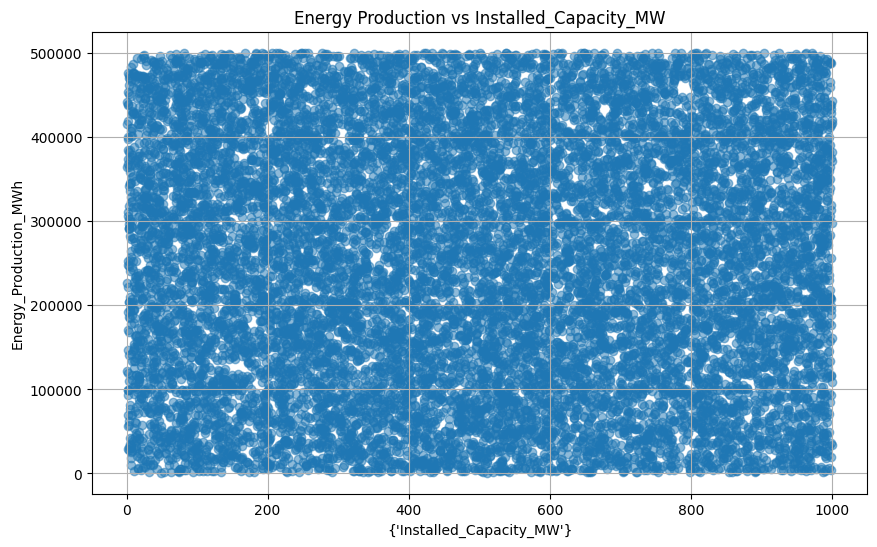

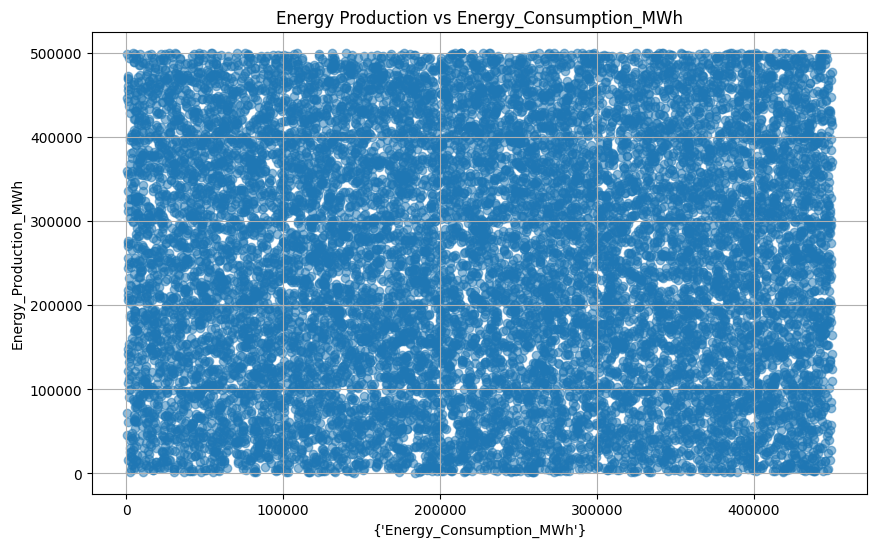

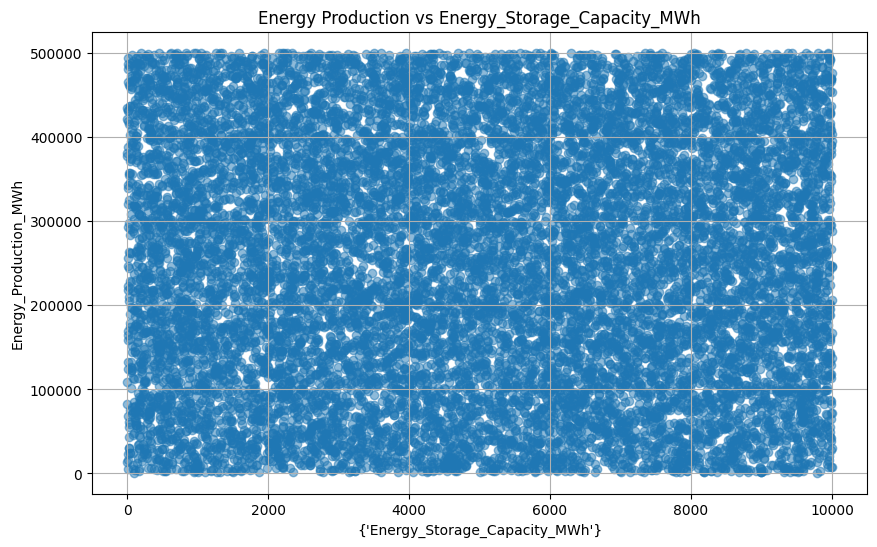

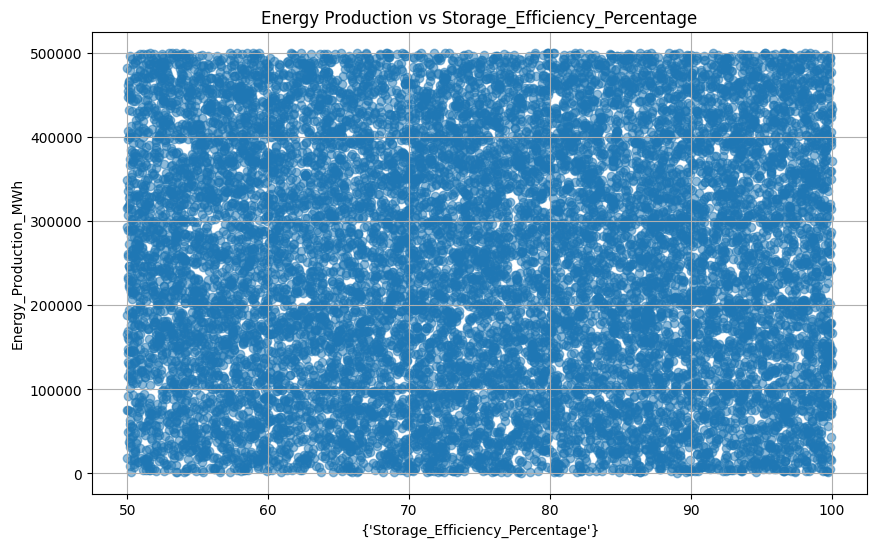

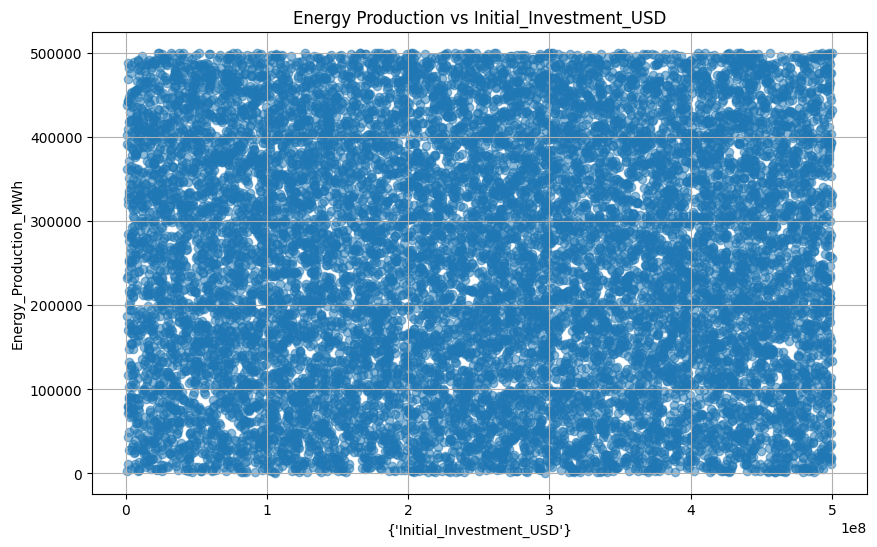

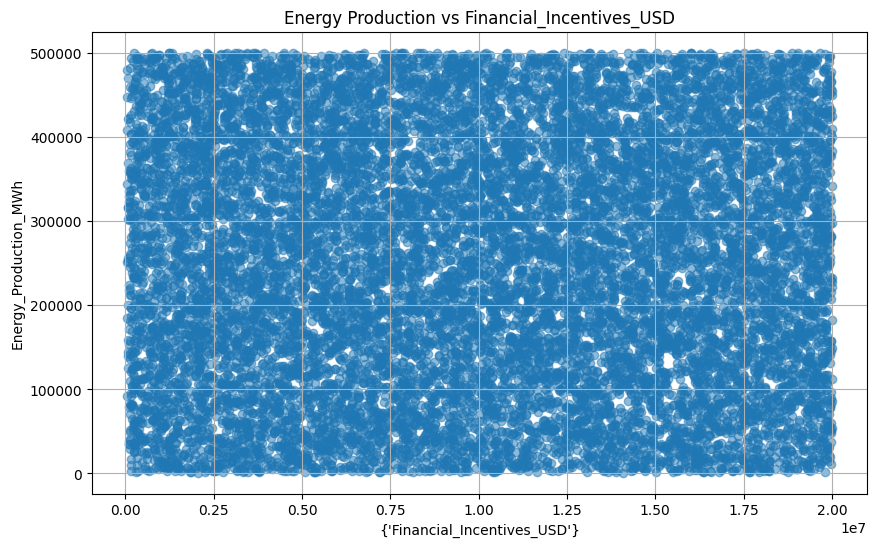

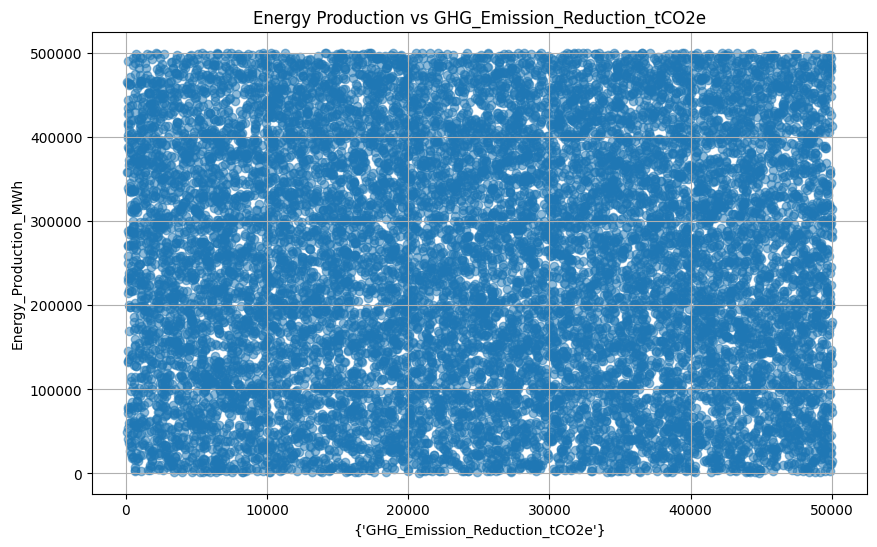

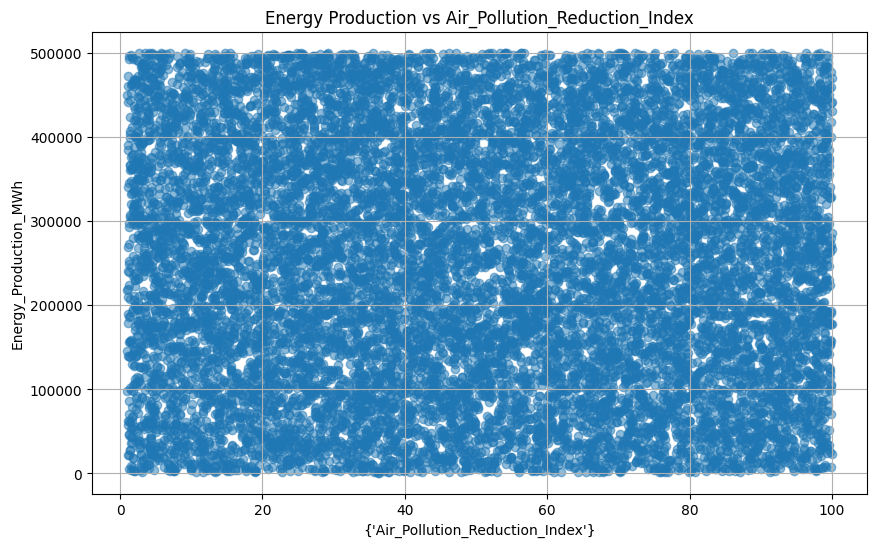

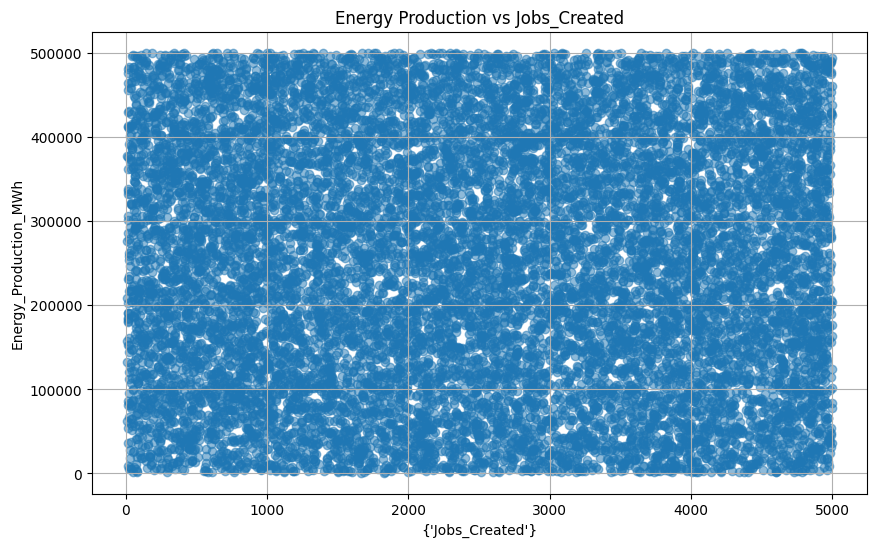

In [77]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev 
from pyspark.sql.types import DoubleType, LongType
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the dataset
data = spark.read.format("csv").option("header", "true").load("energy_dataset_.csv")


data = data.withColumn("Type_of_Renewable_Energy", col("Type_of_Renewable_Energy").cast(LongType())) \
           .withColumn("Installed_Capacity_MW", col("Installed_Capacity_MW").cast(DoubleType())) \
           .withColumn("Energy_Production_MWh", col("Energy_Production_MWh").cast(DoubleType())) \
           .withColumn("Energy_Consumption_MWh", col("Energy_Consumption_MWh").cast(DoubleType())) \
           .withColumn("Energy_Storage_Capacity_MWh", col("Energy_Storage_Capacity_MWh").cast(DoubleType())) \
           .withColumn("Storage_Efficiency_Percentage", col("Storage_Efficiency_Percentage").cast(DoubleType())) \
           .withColumn("Grid_Integration_Level", col("Grid_Integration_Level").cast(LongType())) \
           .withColumn("Initial_Investment_USD", col("Initial_Investment_USD").cast(DoubleType())) \
           .withColumn("Funding_Sources", col("Funding_Sources").cast(LongType())) \
           .withColumn("Financial_Incentives_USD", col("Financial_Incentives_USD").cast(DoubleType())) \
           .withColumn("GHG_Emission_Reduction_tCO2e", col("GHG_Emission_Reduction_tCO2e").cast(DoubleType())) \
           .withColumn("Air_Pollution_Reduction_Index", col("Air_Pollution_Reduction_Index").cast(DoubleType())) \
           .withColumn("Jobs_Created", col("Jobs_Created").cast(LongType()))
data.show(10)



# Data Preparation: prepare caterogical columns - don't need it as they are already indexed
'''
categoricalColumns = ['Type_of_Renewable_Energy', 'Grid_Integration_Level', 'Funding_Sources']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed").fit(data) for column in categoricalColumns]
'''

# Selecting features - columns used to predict other column value
'''
featureCols = ['Type_of_Renewable_Energy', 'Grid_Integration_Level', 'Funding_Sources',
               'Installed_Capacity_MW', 'Energy_Consumption_MWh', 'Energy_Storage_Capacity_MWh',
               'Storage_Efficiency_Percentage', 'Initial_Investment_USD', 'Financial_Incentives_USD',
               'GHG_Emission_Reduction_tCO2e', 'Air_Pollution_Reduction_Index', 'Jobs_Created']
'''
featureCols = ['Installed_Capacity_MW','Initial_Investment_USD']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# Index features - only those that contain 8 or less unique values
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=8)

# Define the Decision Tree Regressor
#, maxDepth=2, minInstancesPerNode=20
dt = DecisionTreeRegressor(featuresCol="indexedFeatures", labelCol="Energy_Production_MWh")

# Splitting the dataset into test and training data
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Clearing cache
spark.catalog.clearCache()

# Create pipeline
pipeline = Pipeline(stages=[assembler, featureIndexer, dt])

# Train the model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Select example rows to display
predictions.select("prediction", "Energy_Production_MWh", "features").show(10)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Energy_Production_MWh", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"root squared mean error (RMSE) on test data = {rmse}")

# Normalized rmse (average error percentage)
summary_stats = data.select(mean("Energy_Production_MWh"), stddev("Energy_Production_MWh")).first()
mean_energy = summary_stats[0]
stddev_energy = summary_stats[1]

print(f"Mean Energy Production: {mean_energy}")
print(f"Standard Deviation of Energy Production: {stddev_energy}")

normalized_rmse = (rmse / mean_energy) * 100
print(f"normalized rmse = {normalized_rmse}%")

# Print the model summary
treeModel = model.stages[-1]
print(treeModel)



allCols = ['Installed_Capacity_MW', 'Energy_Consumption_MWh', 'Energy_Storage_Capacity_MWh',
               'Storage_Efficiency_Percentage', 'Initial_Investment_USD', 'Financial_Incentives_USD',
               'GHG_Emission_Reduction_tCO2e', 'Air_Pollution_Reduction_Index', 'Jobs_Created']

import matplotlib.pyplot as plt


# Plotting the data
for column in allCols:
    energy_production = data.select("Energy_Production_MWh").collect()
    column_values = data.select(column).collect()
    plt.figure(figsize=(10, 6))
    plt.scatter(column_values, energy_production, alpha=0.5)
    plt.title(f"Energy Production vs {column}")
    plt.xlabel({column})
    plt.ylabel("Energy_Production_MWh")
    plt.grid(True)
    plt.show()



spark.stop()


